# How to Automate SQL Database Queries with AI

In this tutorial, we will learn how to automate SQL database queries with the SQL Database Agent. You will learn how to:

- Connect to a SQL database
- Have AI write SQL queries for you from natural language
- Automate the SQL query execution
- Retrieve the results



### Want To Become A Full-Stack Generative AI Data Scientist?

![Generative AI Data Scientist](../img/become_a_generative_ai_data_scientist.jpg)

I teach Generative AI Data Science to help you build AI-powered data science apps. [**Register for my next Generative AI for Data Scientists workshop here.**](https://learn.business-science.io/ai-register)


# Table of Contents

1. [Introduction](#introduction)
2. [Load Libraries](#load-libraries)
3. [Setup AI and Logging](#setup-ai-and-logging)
4. [Connect to a SQL Database](#connect-to-a-sql-database)
5. [Create The Agent](#create-the-agent)
6. [Run the Agent](#run-the-agent)
7. [Response](#response)
    1. [SQL Query Code](#sql-query-code)
    2. [Pandas Data Frame From SQL Query](#pandas-data-frame-from-sql-query)
    3. [Python Pipeline Function](#python-pipeline-function)
    4. [Storage Location](#storage-location)
8. [Free Generative AI Data Science Workshop](#free-generative-ai-data-science-workshop)

### Load Libraries

In [1]:
# * Libraries

from langchain_openai import ChatOpenAI

import pandas as pd
import sqlalchemy as sql

import os
import yaml
from pprint import pprint

from ai_data_science_team.agents import SQLDatabaseAgent

### Setup AI and Logging

This section of code sets up the LLM inputs and the logging information. Logging is used to store AI-generated code and files during the AI Data Science Teams processing of files. 

*Important Note:* This example uses OpenAI's API. But any LLM can be used such as Anthropic or local LLMs with Ollama.

In [2]:
# * Setup

MODEL    = "gpt-4o-mini"
LOG      = True
LOG_PATH = os.path.join(os.getcwd(), "logs/")

os.environ["OPENAI_API_KEY"] = yaml.safe_load(open('../credentials.yml'))['openai']

llm = ChatOpenAI(model = MODEL)

llm


ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x312e1fa60>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x3135db370>, root_client=<openai.OpenAI object at 0x1104bff40>, root_async_client=<openai.AsyncOpenAI object at 0x3135db2b0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

### Connect to a SQL Database

Next, let's connect to the leads data from a SQL database. We will need to use a `sqlalchemy` connection to use the SQL Database Agent.

In [3]:
sql_engine = sql.create_engine("sqlite:///data/northwind.db")

conn = sql_engine.connect()

conn

### Create The Agent

Run this code to create the agent with `SQLDatabaseAgent()`.

The only required parameters are `model` and `connection`. 

- `model` is the LLM model that you want to use.
- `connection` is the sqlalchemy connection to the SQL database.

Other parameters that I've included in this demo are:

- `n_samples`: The number of samples for each table x column to share with the LLM. Reduce this number for large databases to prevent LLM Max Token errors.
- `log`: Set up logging the SQL DB agent's pipeline function
- `log_path`: The directory to save the SQL DB agent's pipeline function
- `bypass_explain_code`: Dynamically bypass the explain code step in the LangGraph DAG. This is useful to speed up response time when you don't need to see the explain code.
- `bypass_recommended_steps`: Dynamically bypass the recommended steps in the LangGraph DAG. This is useful to speed up response time when you don't need to see the recommended steps.

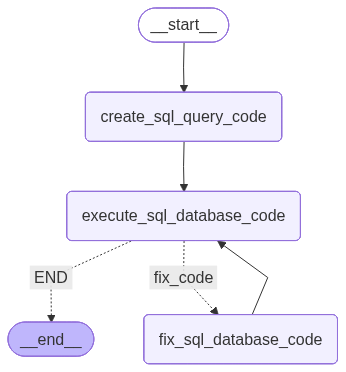

In [4]:
# Make the agent
sql_agent = SQLDatabaseAgent(
    model = llm, 
    connection=conn, 
    n_samples=1, # Needed for large databases to avoid token limits
    log=LOG, 
    log_path=LOG_PATH,
    bypass_explain_code=True,
    bypass_recommended_steps=True,
)

sql_agent

## Run the Agent

The main inputs to the SQL DB Agent are:

- **user_instructions**: What actions you'd like to take on the SQL database query. 
- **max_retries**: Used to limit the number of attempts to fix the SQL and Python code generated by the agent. Set this to 3 to limit to 3 attempts. 
- **retry_count**: Set this to 0. 

In [5]:

sql_agent.invoke_agent(
    user_instructions="What are the sales for each product?",
    max_retries=3,
    retry_count=0,
)

---SQL DATABASE AGENT----
    * CREATE SQL QUERY CODE
    * CREATE PYTHON FUNCTION TO RUN SQL CODE
      File saved to: /Users/mdancho/Desktop/course_code/ai-data-science-team/logs/sql_database.py
    * EXECUTING AGENT CODE ON SQL CONNECTION


### Response

The response produced contains everything we need to understand the data cleaning decisions made and get the cleaned dataset. 

In [6]:
response = sql_agent.get_response()

list(response.keys())

['messages',
 'user_instructions',
 'recommended_steps',
 'data_sql',
 'all_sql_database_summary',
 'sql_query_code',
 'sql_database_function',
 'sql_database_function_path',
 'sql_database_function_file_name',
 'sql_database_function_name',
 'sql_database_error',
 'sql_database_error_log_path',
 'max_retries',
 'retry_count']

#### SQL Query Code

In [7]:
sql_agent.get_sql_query_code(markdown=True)

```sql
SELECT 
    p.ProductName,
    SUM(od.UnitPrice * od.Quantity) AS TotalSales
FROM 
    "Products" p
JOIN 
    "Order Details" od ON p.ProductID = od.ProductID
GROUP BY 
    p.ProductName;
```

#### Pandas Data Frame From SQL Query

In [10]:
pd.DataFrame(sql_agent.get_data_sql())

,ProductName,TotalSales
0,Alice Mutton,7887196.20
1,Aniseed Syrup,2021660.00
2,Boston Crab Meat,3683021.90
3,Camembert Pierrot,6903904.00
4,Carnarvon Tigers,12607487.50
...,...,...
72,Uncle Bob's Organic Dried Pears,6118674.00
73,Valkoinen suklaa,3259798.75
74,Vegie-spread,8811700.40
75,Wimmers gute Semmelknödel,6689800.25


#### Python Pipeline Function

In [9]:
sql_agent.get_sql_database_function(markdown=True)

```python
# Disclaimer: This function was generated by AI. Please review before using.
# Agent Name: sql_database_agent
# Time Created: 2025-12-09 09:14:32


def sql_database_pipeline(connection):
    import pandas as pd
    import sqlalchemy as sql
    
    # Create a connection if needed
    is_engine = isinstance(connection, sql.engine.base.Engine)
    sql_query = '''
    SELECT 
    p.ProductName,
    SUM(od.UnitPrice * od.Quantity) AS TotalSales
FROM 
    "Products" p
JOIN 
    "Order Details" od ON p.ProductID = od.ProductID
GROUP BY 
    p.ProductName;
    '''.strip()
    if is_engine:
        with connection.connect() as conn:
            return pd.read_sql(sql_query, conn)
    return pd.read_sql(sql_query, connection)
        
```

### Want To Become A Full-Stack Generative AI Data Scientist?

![Generative AI Data Scientist](../img/become_a_generative_ai_data_scientist.jpg)

I teach Generative AI Data Science to help you build AI-powered data science apps. [**Register for my next Generative AI for Data Scientists workshop here.**](https://learn.business-science.io/ai-register)